In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
import torchvision.transforms.functional as functional
import torchvision
import torchvision.models as models
from tqdm import tqdm
from sklearn.mixture import GaussianMixture
import pickle
import logging
import os
from scipy.spatial import distance
from handle_dataloader import handle_loader
from shoden_loader import shoden_loader
%matplotlib inline

/opt/miniconda3/envs/develop/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
"""シード値の固定"""
random_seed = 9999
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(random_seed)
    torch.backends.cudnn.deterministic = True
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

import argparse
parser = argparse.ArgumentParser(description='ハイパラに関して')
parser.add_argument('--seed',type=int,default=9999)
args = parser.parse_args()
loader=shoden_loader(args)
train_loader = loader.run('train')
valid_loader = loader.run('valid')
test_loader = loader.run('test')
print(f'train dataset:{len(train_loader.dataset)}')

cuda
train dataset:2875


In [7]:
# model = models.resnet18(pretrained=True)
model = models.resnet18(pretrained=False,num_classes=2)
model.load_state_dict(torch.load('./clst20_del500_custom_result_aug:1_seed:9995/ex5_weights.pth'),strict=False)
model.to(device)
model.eval()
gpu_num=torch.cuda.device_count()
if(gpu_num>1):
        model = nn.DataParallel(model,device_ids=np.arange(gpu_num).tolist())

feat = {
        0:torch.tensor([]).to(device), 1:torch.tensor([]).to(device)
}
train_data = {
        0:torch.tensor([]).to(device), 1:torch.tensor([]).to(device)
        }
trainloop = tqdm(train_loader, unit='batch', desc='| train | Epoch {:>3} |'.format(1))

with torch.no_grad():
    for data,labels,_,_ in trainloop:
        data = data.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)
        feature=model(data)
        for cls in range(2):
                train_data[cls] = torch.cat((train_data[cls],data[labels==cls]))
                feat[cls] = torch.cat((feat[cls],feature[labels==cls]))

# with open("./feature.pkl","wb") as f:
#     pickle.dump(feat, f)

| train | Epoch   1 |: 100%|██████████| 179/179 [00:05<00:00, 30.74batch/s]


In [8]:

def maha_dis(data,mean):
    # 分散共分散行列を計算
    cov = np.cov(data.T,ddof=0)
    # 逆行列を計算
    cov_i = np.linalg.pinv(cov)
    dis=0
    for i in range(data.shape[0]):
        dis+=distance.mahalanobis(data[0], mean, cov_i)
    return dis
    
# """各クラスの最適なクラスタ数のめどをつける"""
# _class = ['ok','ng']
# fig=plt.figure(figsize=(10,15),dpi=100)
# clst_num=15
# for i in range(len(_class)): 
#     _feat = feat[i].to('cpu').detach().numpy().copy()
#     distortions = np.zeros(clst_num)
#     for j in range(1,clst_num+1): 
#         dis=0
#         gmm = GaussianMixture(n_components=j,max_iter=30,random_state=random_seed)
#         gmm.fit(_feat)
#         _pred = gmm.predict(_feat)
#         """クラスタｋのマハラノビス距離"""
#         for k in range(j):
#             dis += maha_dis(_feat[_pred==k],gmm.means_[k])
#         distortions[j-1] = dis
#         print(dis)
        
#     print(distortions)
#     ax = fig.add_subplot(len(_class),1,i+1)
#     ax.plot(np.arange(1,clst_num+1),distortions,marker="o")
#     ax.set_xticks(range(1,clst_num+1))
#     ax.set_title(f"{_class[i]}")
#     ax.set_xlabel("Number of clusters")
#     ax.set_ylabel("Distortion")
#     ax.legend(''.join(f"{_class[i]}"), loc='upper right')
#     plt.tight_layout()
# plt.show()

(278, 2)
(0,11) (1,30) (2,10) (3,9) (4,2) (5,15) (6,15) (7,17) (8,1) (9,7) (10,3) (11,39) (12,10) (13,40) (14,15) (15,7) (16,16) (17,12) (18,6) (19,13) 

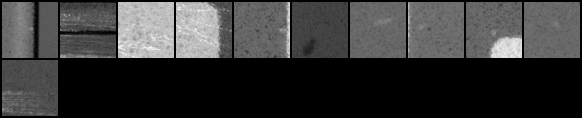

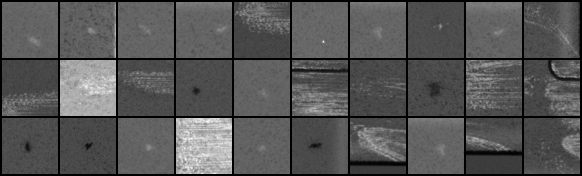

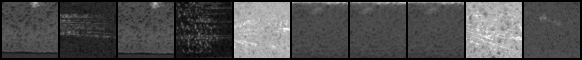

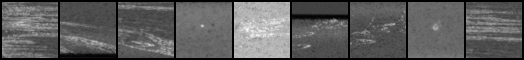

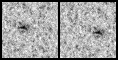

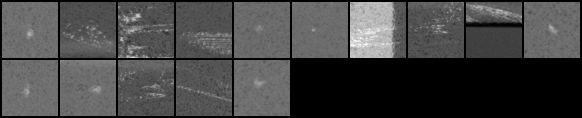

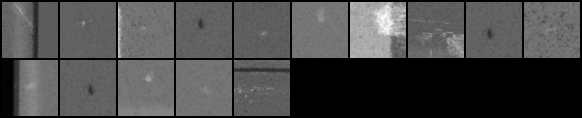

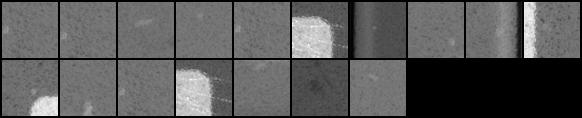

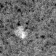

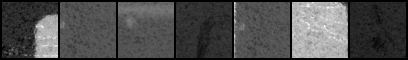

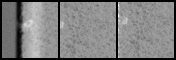

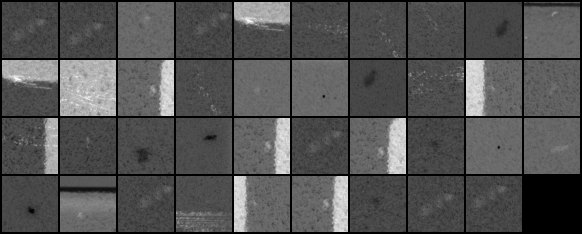

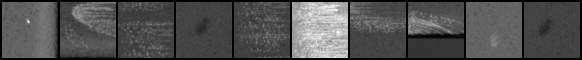

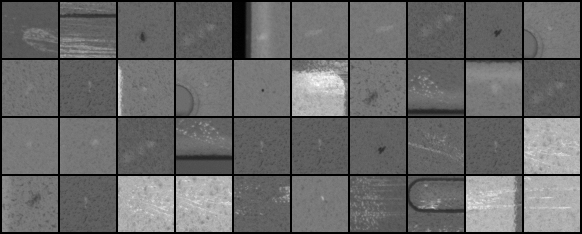

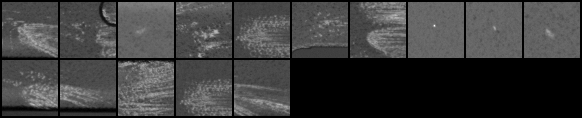

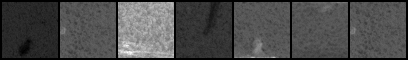

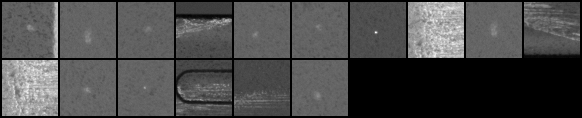

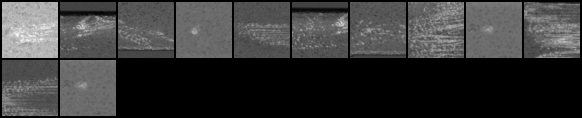

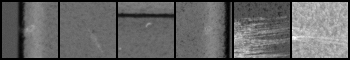

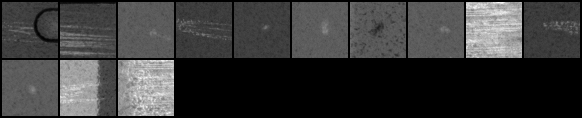

In [15]:

target='ng'
_class = ['ok','ng']
cluster=[25,20]
index=_class.index(target)
num_clusters = cluster[index]
_feat=feat[index].to('cpu').detach().numpy().copy()

model = GaussianMixture(n_components=num_clusters,max_iter=30,random_state=random_seed)
model.fit(_feat)
pred = model.predict(_feat)
print(_feat.shape)
# 各クラスタの枚数確認
for i in range(num_clusters):
    print(f'({i},{train_data[index][pred==i].shape[0]})',end=' ')
for i in range(num_clusters):
    x = train_data[index][pred==i][:100]
    # print(x)
    img = torchvision.utils.make_grid(x,nrow=10,normalize=True)
    img = functional.to_pil_image(img)
    display(img)

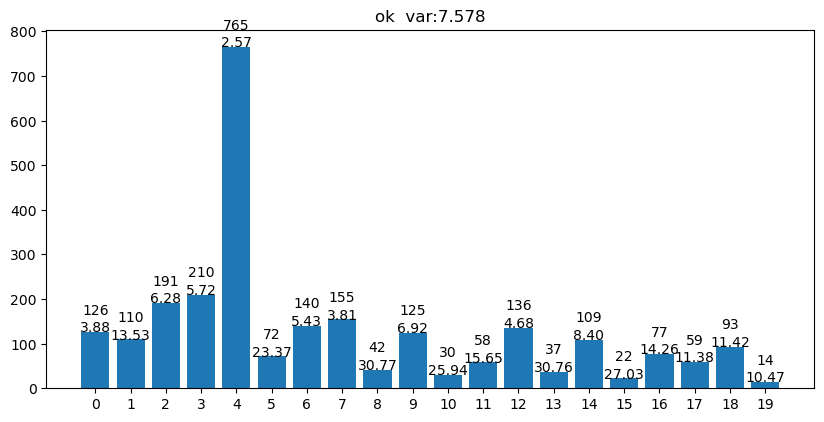

In [50]:
fig_bar = plt.figure(figsize=(24, 16), dpi=100)
for i in range(1):    
    _feat = feat[i].to('cpu').detach().numpy().copy()
    _model = GaussianMixture(n_components=cluster[i],max_iter=30,random_state=random_seed)
    _model.fit(_feat)
    
    """各クラス間の分散及び、各クラスタ分散"""
    pred = _model.predict(_feat)
    height=np.array([len(pred[pred==j]) for j in range(cluster[i])])
    iner_var=np.array([(np.var(_feat[pred==k]))for k in range(cluster[i])])
    text = np.array([f'{iner_var[l]:.02f}' for l in range(cluster[i])])
    ax = fig_bar.add_subplot(4,3,i+1)
    ax.bar(np.arange(cluster[i]),height)
    ax.set_xticks(np.arange(cluster[i]))
    ax.set_title(f'{_class[i]}  var:{np.var(_feat):.03f}')
    for t in range(cluster[i]):
        ax.text(x=t,y=height[t],s=text[t],ha='center') 
        ax.text(x=t,y=height[t]+40,s=str(height[t]),ha='center') 
    fig_bar.tight_layout()
fig_bar.show()

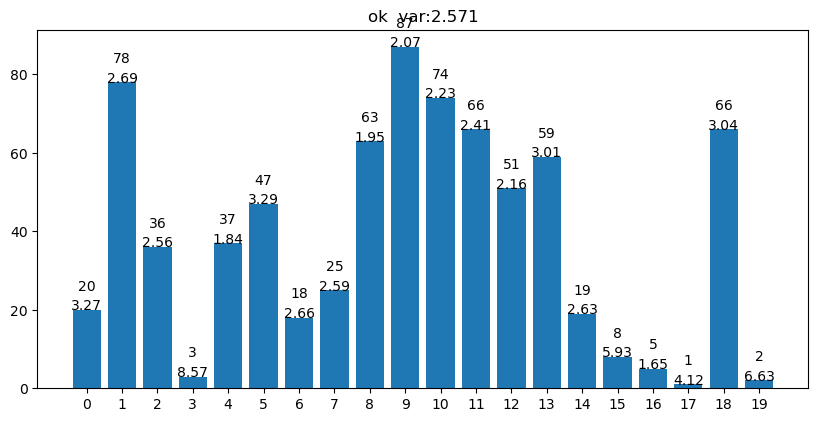

In [51]:
fig_bar = plt.figure(figsize=(24, 16), dpi=100)
for i in range(1):    
    _feat = feat[i].to('cpu').detach().numpy().copy()
    model = GaussianMixture(n_components=20,max_iter=30,random_state=random_seed)
    model.fit(_feat)
    pred = model.predict(_feat)
    _feat = _feat[pred==4]
    _model = GaussianMixture(n_components=20,max_iter=30,random_state=random_seed)
    _model.fit(_feat)
    _pred = _model.predict(_feat)
    
    height=np.array([len(_pred[_pred==j]) for j in range(20)])
    iner_var=np.array([(np.var(_feat[_pred==k]))for k in range(20)])
    text = np.array([f'{iner_var[l]:.02f}' for l in range(20)])
    ax = fig_bar.add_subplot(4,3,i+1)
    ax.bar(np.arange(20),height)
    ax.set_xticks(np.arange(20))
    ax.set_title(f'{_class[i]}  var:{np.var(_feat):.03f}')
    for t in range(20):
        ax.text(x=t,y=height[t],s=text[t],ha='center') 
        ax.text(x=t,y=height[t]+5,s=str(height[t]),ha='center') 
    fig_bar.tight_layout()
fig_bar.show()

In [ ]:
from sklearn.decomposition import PCA

_feat = feat[0].to('cpu').detach().numpy().copy()
_model = GaussianMixture(n_components=20,max_iter=30,random_state=random_seed)
_model.fit(_feat)
pred = _model.predict(_feat)
# 元の特徴量と同じ数で主成分分析
print(_feat[pred==4].shape)
pca = PCA(n_components=30)
pca.fit(_feat[pred==4])
plt.bar([n for n in range(1, len(pca.explained_variance_ratio_)+1)], pca.explained_variance_ratio_)
np.set_printoptions(precision=5, suppress=True) # numpyの小数点以下表示桁数と、指数表記設定
print('explained variance ratio: {}'.format(pca.explained_variance_ratio_))
pca.explained_variance_ratio_[0:10].sum()
